In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns



## Initial GPU Setup

In [2]:
# Disable eager execution to prevent early GPU initialization
tf.compat.v1.disable_eager_execution()

# Set GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
print("Eager execution:", tf.executing_eagerly())

# Enable eager execution if it's not already (relevant for TensorFlow 1.x)
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

Eager execution: False








## Data Preprocessing

In [4]:

def fen_to_binary_planes(fen_string):
    # Map for piece type to index of binary plane
    piece_to_index = {
        'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
        'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
    }

    board_tensor = np.zeros((8, 8, 12), dtype=np.float32)
    
    # Spliting the FEN string to get all of its 'components'
    board_part, active_color, castling, en_passant, halfmove_clock, fullmove_number = fen_string.split(' ')
    
    # Replace digits in FEN with corresponding number of '.'
    for digit in '12345678':
        board_part = board_part.replace(digit, '.' * int(digit))
    
    # Removing '/' to create a single string representing the board
    board_part = board_part.replace('/', '')
    
    for i, char in enumerate(board_part):
        if char in piece_to_index:
            # Calculate the row and column from the index
            row, col = divmod(i, 8)
            # Set the value at the corresponding place in the tensor
            board_tensor[row, col, piece_to_index[char]] = 1
    
    # Extra features: Active color and castling rights
    active_color_plane = np.zeros((8, 8, 1), dtype=np.float32)
    if active_color == 'w':
        active_color_plane.fill(1)
    
    castling_planes = np.zeros((8, 8, 4), dtype=np.float32)
    castling_rights = {'K': 0, 'Q': 1, 'k': 2, 'q': 3}
    for char in castling:
        if char in castling_rights:
            castling_planes[:, :, castling_rights[char]].fill(1)
    
    # Stack all planes to form the final board representation tensor
    board_tensor = np.concatenate((board_tensor, active_color_plane, castling_planes), axis=-1)
    
    return board_tensor

# Example usage
fen_string = "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"
fen_tensor = fen_to_binary_planes(fen_string)
fen_tensor

array([[[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.]],

       ...,

       [[0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        ...,
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 1., 1.

In [5]:
data = pd.read_csv('../chess_evaluations.csv')
data

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,24
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,22
2,rnbqkbnr/pppp1ppp/8/4p3/4PP2/8/PPPP2PP/RNBQKBN...,-41
3,rnbqkbnr/pppp1ppp/8/8/4Pp2/8/PPPP2PP/RNBQKBNR ...,-42
4,rnbqkbnr/pppp1ppp/8/8/4Pp2/5N2/PPPP2PP/RNBQKB1...,-48
...,...,...
3460278,r2q1kr1/2pb1p2/1p1p4/p2Pp1pn/P1P1P2p/2N1QP1P/1...,-20
3460279,r2q1kr1/2pb1p2/1p1p4/p2Pp1pn/P1P1P2p/4QP1P/1P2...,-30
3460280,r2q1k2/2pb1p2/1p1p2r1/p2Pp1pn/P1P1P2p/4QP1P/1P...,24
3460281,r2q1k2/2pb1p2/1p1p2r1/p2Pp1pn/P1P1P2p/4QP1P/1P...,4


In [6]:
data['Fen Binary Plane'] = data['FEN'].apply(fen_to_binary_planes)
data.head(5)


,FEN,Evaluation,Fen Binary Plane
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,24,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,22,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,rnbqkbnr/pppp1ppp/8/4p3/4PP2/8/PPPP2PP/RNBQKBN...,-41,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,rnbqkbnr/pppp1ppp/8/8/4Pp2/8/PPPP2PP/RNBQKBNR ...,-42,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,rnbqkbnr/pppp1ppp/8/8/4Pp2/5N2/PPPP2PP/RNBQKB1...,-48,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [7]:
Q1 = data['Evaluation'].quantile(0.25)
Q3 = data['Evaluation'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['Evaluation'] >= lower_bound) & (data['Evaluation'] <= upper_bound)]
data

,FEN,Evaluation,Fen Binary Plane
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,24,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,22,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,rnbqkbnr/pppp1ppp/8/4p3/4PP2/8/PPPP2PP/RNBQKBN...,-41,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,rnbqkbnr/pppp1ppp/8/8/4Pp2/8/PPPP2PP/RNBQKBNR ...,-42,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,rnbqkbnr/pppp1ppp/8/8/4Pp2/5N2/PPPP2PP/RNBQKB1...,-48,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
...,...,...,...
3460278,r2q1kr1/2pb1p2/1p1p4/p2Pp1pn/P1P1P2p/2N1QP1P/1...,-20,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3460279,r2q1kr1/2pb1p2/1p1p4/p2Pp1pn/P1P1P2p/4QP1P/1P2...,-30,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3460280,r2q1k2/2pb1p2/1p1p2r1/p2Pp1pn/P1P1P2p/4QP1P/1P...,24,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3460281,r2q1k2/2pb1p2/1p1p2r1/p2Pp1pn/P1P1P2p/4QP1P/1P...,4,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [8]:

# Normalizing the evaluation column
scaler_eval = StandardScaler()
normalized_evaluations = scaler_eval.fit_transform(data['Evaluation'].values.reshape(-1, 1)).flatten()


In [9]:
fen_binary_planes = np.stack(data['Fen Binary Plane'].values)


## Dataset Preparation

In [10]:
train_val_X, test_X, train_val_y, test_y = train_test_split(
    fen_binary_planes, normalized_evaluations, test_size=0.025, random_state=42
)

# Split the training data to get a validation dataset
train_X, val_X, train_y, val_y = train_test_split(
    train_val_X, train_val_y, test_size=0.05, random_state=42
)

In [11]:
batch_size = 32

def generate_batches(X, y, batch_size):
    total_batches = 0
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i + batch_size]
        y_batch = y[i:i + batch_size]
        X_batch = X_batch.reshape(-1, 8, 8, 17)
        total_batches += 1
        yield X_batch, y_batch


def train_generator():
    return generate_batches(train_X, train_y, batch_size)

def val_generator():
    return generate_batches(val_X, val_y, batch_size)

def test_generator():
    return generate_batches(test_X, test_y, batch_size)


In [12]:
# Define output types and shapes
output_types = (tf.float32, tf.float32)
output_shapes = ((None, 8, 8, 17), (None,))  # 'None' for the variable batch dimension

train_dataset = tf.data.Dataset.from_generator(
    train_generator, output_types=output_types, output_shapes=output_shapes
).shuffle(buffer_size=10000).repeat().prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    val_generator, output_types=output_types, output_shapes=output_shapes
).repeat().prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_generator(
    test_generator, output_types=output_types, output_shapes=output_shapes
).shuffle(buffer_size=10000).prefetch(tf.data.experimental.AUTOTUNE)





In [13]:
for x_batch, y_batch in train_dataset.take(1):
    print("Batch shape:", x_batch.shape)
    print("Number of samples in batch:", len(x_batch))



Batch shape: (32, 8, 8, 17)
Number of samples in batch: 32


## Model Implementation

In [26]:
model = tf.keras.Sequential([
    Flatten(input_shape=[8, 8, 17]),
    
    Dense(2176),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),
    
    Dense(136),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),
    
    Dense(1),
    Activation('linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])



model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 1088)              0         
                                                                 
 dense_6 (Dense)             (None, 2176)              2369664   
                                                                 
 batch_normalization_4 (Batc  (None, 2176)             8704      
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 2176)              0         
                                                                 
 dropout_4 (Dropout)         (None, 2176)              0         
                                                                 
 dense_7 (Dense)             (None, 136)               296072    
                                                      

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1, mode="auto", restore_best_weights=True)  

reduce_on_plateu = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=5,verbose=1,mode="auto",min_lr=0.0001,)

train_steps = len(train_X) // batch_size
val_steps = len(val_X) // batch_size

num_epochs = 100
history = model.fit(
  train_dataset, 
  steps_per_epoch=train_steps,
  epochs=num_epochs, 
  validation_data=val_dataset, 
  validation_steps=val_steps,
  callbacks=[early_stopping, reduce_on_plateu],
)


Epoch 1/100
81427/81427 [==============================] - 385s 5ms/step - loss: 0.8221 - mean_absolute_error: 0.6330 - val_loss: 0.7383 - val_mean_absolute_error: 0.5911 - lr: 0.0010
Epoch 2/100
81427/81427 [==============================] - 398s 5ms/step - loss: 0.7431 - mean_absolute_error: 0.5970 - val_loss: 0.6721 - val_mean_absolute_error: 0.5589 - lr: 0.0010
Epoch 3/100
81427/81427 [==============================] - 409s 5ms/step - loss: 0.6949 - mean_absolute_error: 0.5773 - val_loss: 0.6260 - val_mean_absolute_error: 0.5363 - lr: 0.0010
Epoch 4/100
81427/81427 [==============================] - 406s 5ms/step - loss: 0.6553 - mean_absolute_error: 0.5612 - val_loss: 0.5841 - val_mean_absolute_error: 0.5157 - lr: 0.0010
Epoch 5/100
81427/81427 [==============================] - 400s 5ms/step - loss: 0.6239 - mean_absolute_error: 0.5484 - val_loss: 0.5544 - val_mean_absolute_error: 0.5060 - lr: 0.0010
Epoch 6/100
81427/81427 [==============================] - 428s 5ms/step - loss:

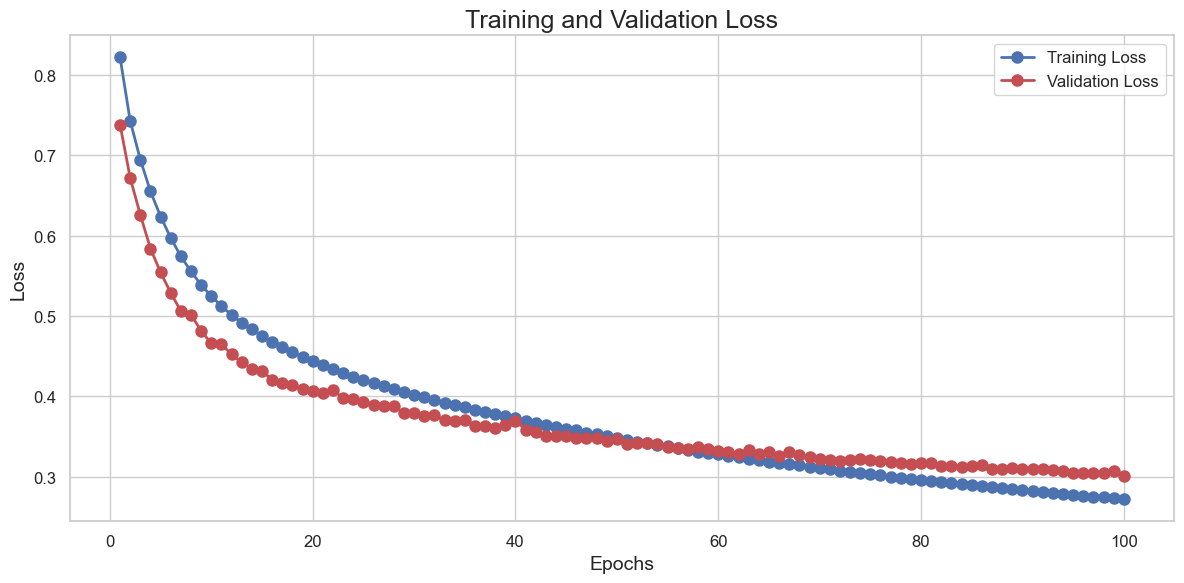

In [28]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Set the style of the seaborn plot
sns.set(style='whitegrid')

# Create a figure and a set of subplots
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.plot(epochs, training_loss, 'bo-', label='Training Loss', linewidth=2, markersize=8)
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss', linewidth=2, markersize=8)

# Title and labels
plt.title('Training and Validation Loss', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Legend
plt.legend(fontsize=12)

# Modify the tick parameters
plt.tick_params(labelsize=12)

# Show the plot with a tight layout
plt.tight_layout()

plt.show()



In [29]:
def invert_normalization_evaluations(normalized_data, scaler):
    # Reshape normalized_data to a 2D array as required by inverse_transform
    reshaped_data = normalized_data.reshape(-1, 1)
    
    # Invert the normalization
    original_data = scaler.inverse_transform(reshaped_data).flatten()
    
    return original_data

In [30]:
test_loss = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")

2198/2198 [==============================] - 6s 3ms/step - loss: 0.3030 - mean_absolute_error: 0.3605
Test Loss: [0.30299022793769836, 0.36052900552749634]


2198/2198 [==============================] - 3s 1ms/step
(70329,)
(70329,)


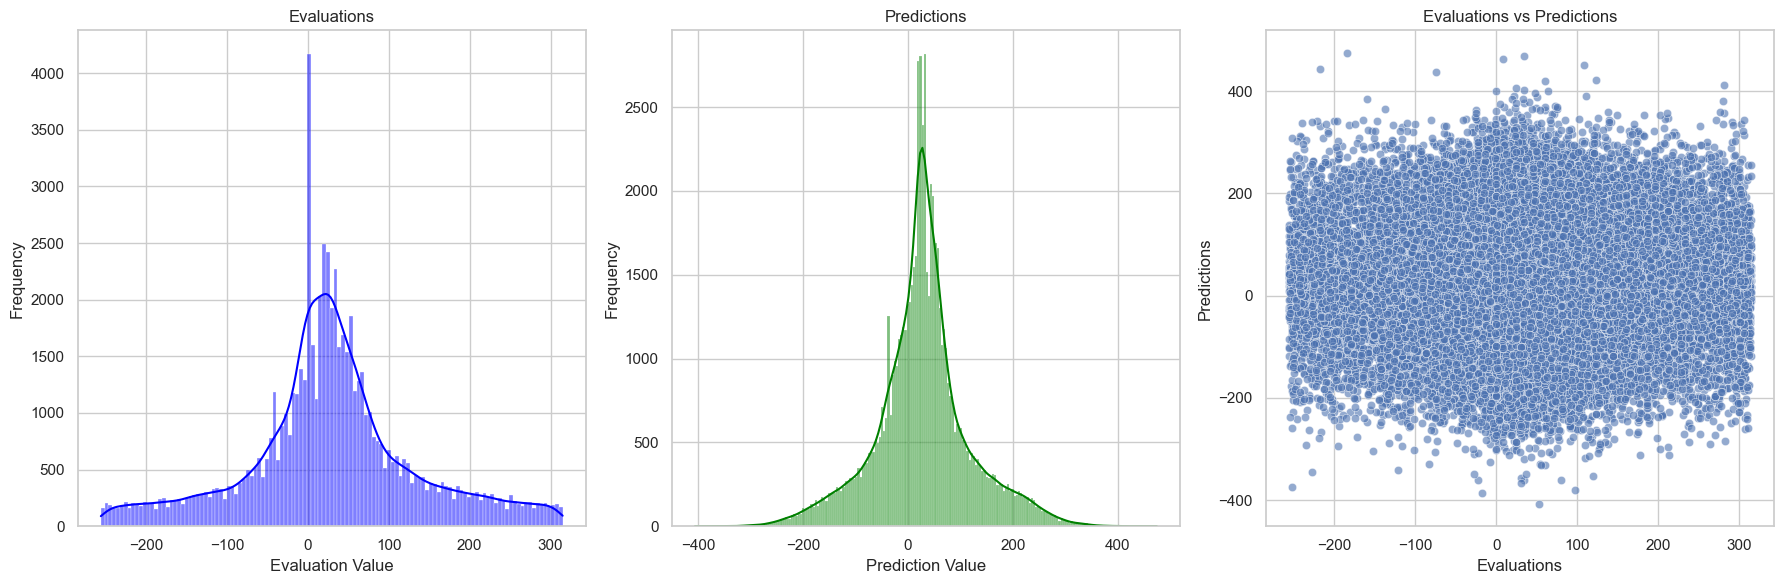

In [31]:



predictions = model.predict(test_dataset)
predictions = invert_normalization_evaluations(predictions, scaler_eval)
evaluations = np.array(invert_normalization_evaluations(test_y, scaler_eval)).flatten()
predictions = np.array(predictions).flatten()

print(test_y.shape)
print(predictions.shape)

# Creates a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# First plot: Evaluations
sns.histplot(evaluations, ax=axes[0], color='blue', kde=True)
axes[0].set_title('Evaluations')
axes[0].set_xlabel('Evaluation Value')
axes[0].set_ylabel('Frequency')

# Second plot: Predictions
sns.histplot(predictions, ax=axes[1], color='green', kde=True)
axes[1].set_title('Predictions')
axes[1].set_xlabel('Prediction Value')
axes[1].set_ylabel('Frequency')

# Third plot: Scatter plot of Evaluations vs Predictions
sns.scatterplot(x=evaluations, y=predictions, ax=axes[2], alpha=0.6)
axes[2].set_title('Evaluations vs Predictions')
axes[2].set_xlabel('Evaluations')
axes[2].set_ylabel('Predictions')

plt.tight_layout()
plt.show()

In [32]:
prediction = model.predict(data['Fen Binary Plane'].values[4].reshape(1, 8, 8, 17))
prediction = invert_normalization_evaluations(prediction, scaler_eval)
prediction[0]

1/1 [==============================] - 0s 80ms/step


-50.577587

In [33]:
data['Evaluation'].values[4]

-48

In [34]:
model.save('FF_model_V4.h5')